In [1]:
!pip install hydra-core --upgrade -qq
# exit(0)

In [2]:
!pip install lightly -qq

In [3]:
# os.listdir("./")
import os
os.cpu_count()

2

## THE START....
---  --- 

In [4]:
"""

**** REFERENCES RESOURCES: *********


https://theaisummer.com/simclr/

https://github.com/sadimanna/simclr_pytorch/blob/main/SImCLR_cifar10.ipynb

https://towardsdatascience.com/train-without-labeling-data-using-self-supervised-learning-by-relational-reasoning-b0298ad818f9



"""
print("Updated Reference Resources")

Updated Reference Resources


In [5]:
# # !pip install pytorch-lightning

# !pip install git+https://github.com/PyTorchLightning/pytorch-lightning
# import pytorch_lightning as pl
# print(pl.__version__)
# # exit(0)

In [6]:

# import libraries to be used
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm



# torch modules for dealing with model and images
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F

# torch lighting to be used for training
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

%matplotlib inline


In [7]:
# tensorboard
%load_ext tensorboard


In [8]:

# model to be saved path
CHECKPOINT_PATH = "./"


NUM_WORKERS = 2
NUM_WORKERS

2

In [9]:
pl.seed_everything(0)

device = torch.device("cuda:0")


In [10]:
# set all activities on gpu
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Data Augumentation

In [11]:
class contrastTransformation(object):
    """
    A single image prediction output will be evaluated, In this case, a single image batch will need to have tow samples so that their results can be compaired.
    i.e preparing the data loading  to have  two different, random augmentations for each single image in the batch. 
    This will be done by this transfomer class which normally is caled contrast transfomation

    """
    def __init__(self, general_transforms, sample_img_views=2):
        self.general_transforms = general_transforms
        self.sample_img_views = sample_img_views

    def __call__(self, x):
        #transfom the images
        return [self.general_transforms(x) for i in range(self.sample_img_views)]

In [12]:
"""
Create Some Transformations rto be used

THe direction was that we apply the following:
    1. Color Distortion
    2. Cropping and Resizing to original Shape In this case 32by 32 as incase of cifar10
    3. Random Gausina Blur
"""



def get_transfomations():
    trans_items =[
        transforms.RandomApply([transforms.ColorJitter(brightness=0.51,contrast=0.35,saturation=0.55,hue=0.091)], p=0.75), #Colow Distorition 
        transforms.RandomResizedCrop(size=32),#Cropping and Resizing size to be 32 by 32
        transforms.GaussianBlur(kernel_size=5), #Gausian Blurring
        transforms.ToTensor(),#convert to tensor
        transforms.Normalize((0.5,), (0.5,)) #normalize the pixels
    ]
    return transforms.Compose(trans_items)



# get all transformation to be used
transforms_ftns = get_transfomations()

transforms_ftns

Compose(
    RandomApply(
    p=0.75
    ColorJitter(brightness=[0.49, 1.51], contrast=[0.65, 1.35], saturation=[0.44999999999999996, 1.55], hue=[-0.091, 0.091])
)
    RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

In [13]:
# each image will have 2 samples
cifar10_data = torchvision.datasets.CIFAR10(
    "datasets/cifar10", download=True,
    transform=contrastTransformation(get_transfomations(), 
                                         sample_img_views=2))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10


In [14]:
# train data 
cifar10_data_val = torchvision.datasets.CIFAR10(
    "datasets/cifar10", train=False, download=True,  
    transform=contrastTransformation(get_transfomations(), 
                                         sample_img_views=2))

Files already downloaded and verified


In [15]:
len(cifar10_data), len(cifar10_data_val)

(50000, 10000)

In [16]:
cifar10_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/cifar10
    Split: Train
    StandardTransform
Transform: <__main__.contrastTransformation object at 0x7fadc686afd0>

### View Sample Images

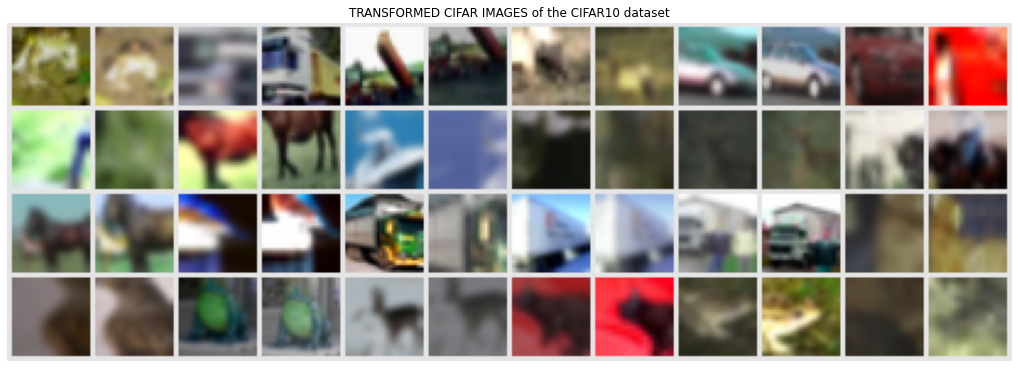

In [17]:
# Visualize some examples

plt.figure(figsize=(18,10))
plt.title('TRANSFORMED CIFAR IMAGES of the CIFAR10 dataset')
plt.imshow(
    torchvision.utils.make_grid(torch.stack([img for idx in range(24) for img in cifar10_data[idx][0]], dim=0), nrow=12, normalize=True, pad_value=0.9).permute(1, 2, 0)
)
plt.axis('off')
plt.show()
plt.close()

In [18]:
"""
In each image, the images are slightly different because of the transformation that they have undergone.
Each Image has its partner. The model needs to match the two images 
"""

'\nIn each image, the images are slightly different because of the transformation that they have undergone.\nEach Image has its partner. The model needs to match the two images \n'

### SIMCR MODEL Definition

In [19]:
# some params definition
MODEL_TEMP = 0.05
EPOCHS = 4
WEIGHT_DECAY = 1e3
LEARNING_RATE= 3e3
HIDDEN_DIM = 128

In [20]:




class SimCLR(pl.LightningModule):

    def __init__(self,  hidden_dim, lr, temperature, weight_decay, max_epochs=10):
        super().__init__()
        self.save_hyperparameters()
    
        #load the model without pretrained weights
        self.resnet18 = torchvision.models.resnet18(
            pretrained=False,num_classes=2*hidden_dim
            )
        #add mlp layers to the resnet model
        self.resnet18.fc = nn.Sequential(
            self.resnet18.fc,  
            nn.ReLU(inplace=True),
            nn.Linear(2*hidden_dim, hidden_dim)
        )


    def configure_optimizers(self):

        optimizer = [torch.optim.AdamW(self.parameters(),lr=self.hparams.lr,weight_decay=self.hparams.weight_decay)]
        lr_scheduler = [torch.optim.lr_scheduler.CosineAnnealingLR(optimizer[0],T_max=self.hparams.max_epochs,eta_min=self.hparams.lr/50)]
        return optimizer, lr_scheduler

    def inference_model_loss_information(self, img_batch, train=True):

        """Only Images are used and their Labels are being Ignored"""
        curr_imgs, _ = img_batch
        curr_imgs = torch.cat(curr_imgs, dim=0)

        """Pass the Images through the Network for self Training"""
        preds_features = self.resnet18(curr_imgs)

        """The model results Will be compaired How similar their Are i,e If the model is able to distinguish two similar Images"""
        cos_similarity_res = torch.nn.functional.cosine_similarity(preds_features[:,None,:], preds_features[None,:,:], dim=-1)
        #create a mask of the similarity
        self_mask = torch.eye(cos_similarity_res.shape[0], dtype=torch.bool, device=cos_similarity_res.device)
        # Fill hte sim with the masks
        cos_similarity_res.masked_fill_(self_mask, -9e15)

        #find positive results from the batch images i,e we have two images instances for each
        positive_mask = self_mask.roll(shifts=cos_similarity_res.shape[0]//2, dims=0)
    
        #get nce loss
        cos_similarity_res = cos_similarity_res /self.hparams.temperature
        nce_loss = -cos_similarity_res[positive_mask] + torch.logsumexp(cos_similarity_res, dim=-1)
        #print(nce_loss)
        nce_loss = nce_loss.mean()

        # Logging loss
        if train:
            mode = 'training'
            self.log(mode+'_loss', nce_loss)
            total_loss.append(nce_loss)
        else:
            mode ='validating'
            self.log(mode+'_loss', nce_loss)
            val_total_loss.append(nce_loss)
        
        
        #rank the postive res
        comb_sim = torch.cat([cos_similarity_res[positive_mask][:,None],cos_similarity_res.masked_fill(positive_mask, -9e15)],dim=-1)
        similarity_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

        #log the metric results
        self.log(mode+'_acc_top_1', (similarity_argsort == 0).float().mean())
        self.log(mode+'_acc_top_5', (similarity_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+similarity_argsort.float().mean())

        #add these metrucs to a liss for further visualization
        if train:
            top_1_acc.append((similarity_argsort == 0).float().mean())
            top_5_acc.append((similarity_argsort < 5).float().mean())
        else:
            val_top_1_acc.append((similarity_argsort == 0).float().mean())
            val_top_5_acc.append((similarity_argsort < 5).float().mean())
        return nce_loss

    def training_step(self, batch, batch_idx):
        """Training step"""
        return self.inference_model_loss_information(batch)

    def validation_step(self, batch, batch_idx):
        """Validation stem"""
        self.inference_model_loss_information(batch, False)


In [21]:
len(cifar10_data[0]), 
cifar10_data[0][0][0].shape

torch.Size([3, 32, 32])

In [22]:
# import torch 
# import torch.nn as nn 
# class SimCLR_Model(torch.nn.Module):
#     def __init__(self, hidden_dim):
#         super(SimCLR_Model,self).__init__()

#         #load the model without pretrained weights
#         self.resnet18 = torchvision.models.resnet18(
#             pretrained=False,num_classes=2*hidden_dim
#             )
#         #add mlp layers to the resnet model
#         self.resnet18.fc = nn.Sequential(
#             self.resnet18.fc,  
#             nn.ReLU(inplace=True),
#             nn.Linear(2*hidden_dim, hidden_dim)
#         )


#     def forward(self,inputs):
#         res = self.resnet18(inputs)

#         return res



In [23]:
def train_simclr(batch_size, max_epochs=250, **kwargs):
    """
    This Function Trains the SIMCLR model usingtorch lightting
    """

    #set model params
    simclr_trainer = pl.Trainer(default_root_dir='./SimCLR',gpus=1 if str(device)=='cuda:0' else 0,
                                max_epochs=max_epochs,
                                callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='validating_acc_top_5'),
                                           LearningRateMonitor('epoch')])
    #stop model default logging

    simclr_trainer.logger._default_hp_metric = None

    #IF the model is saved already, load it else continue training and validation
    pretrained_model_checkpoint = os.path.join("./", 'SimCLR.ckpt')
    if os.path.isfile(pretrained_model_checkpoint):
        print(f'Loading Model Already Saved In  {pretrained_model_checkpoint} ......')
        #load the model with its states dict
        model = SimCLR.load_from_checkpoint(pretrained_model_checkpoint)
    else:
        training_data_loader = data.DataLoader(cifar10_data, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True, pin_memory=True)
        val_data_loader = data.DataLoader(cifar10_data_val, batch_size=batch_size, shuffle=False, num_workers=2,drop_last=True, pin_memory=True)
        #setting seed to get similar results always
        pl.seed_everything(2022)
        #initialize the model and train it
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        simclr_trainer.fit(model, training_data_loader, val_data_loader)
        #get the best model
        model = SimCLR.load_from_checkpoint(simclr_trainer.checkpoint_callback.best_model_path)

    return model



In [24]:
!rm -r ./SimCLR

rm: cannot remove './SimCLR': No such file or directory


In [25]:

total_loss =[]
top_1_acc =[]
top_5_acc =[]


val_total_loss =[]
val_top_1_acc =[]
val_top_5_acc =[]


MODEL_TEMP = 0.075
EPOCHS = 2
WEIGHT_DECAY = 1e4
LEARNING_RATE= 5e-4
HIDDEN_DIM = 128
BATCH_SIZE=256
simclr_model = train_simclr(batch_size=256,hidden_dim=128,weight_decay=1e-4,max_epochs=25,lr=2e-4,temperature=0.08)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

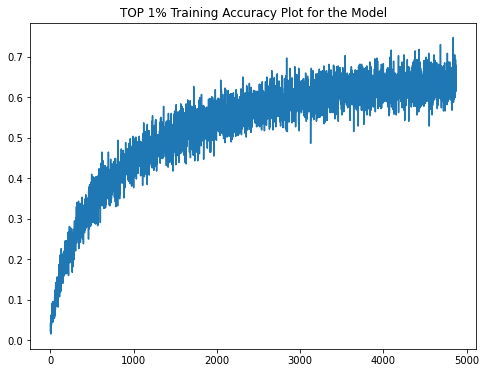

In [26]:
plt.figure(figsize=(8,6))
plt.title("TOP 1% Training Accuracy Plot for the Model")
plt.plot([x.detach().item()  for x in top_1_acc])

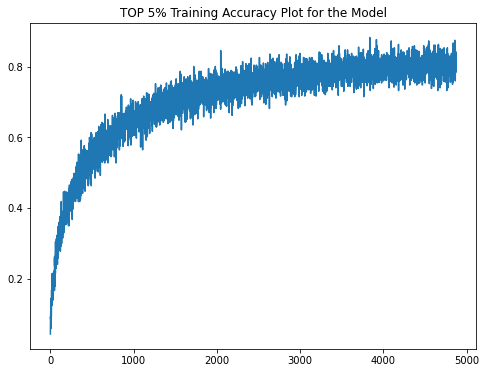

In [27]:
plt.figure(figsize=(8,6))
plt.title("TOP 5% Training Accuracy Plot for the Model")
plt.plot([x.detach().item()  for x in top_5_acc])

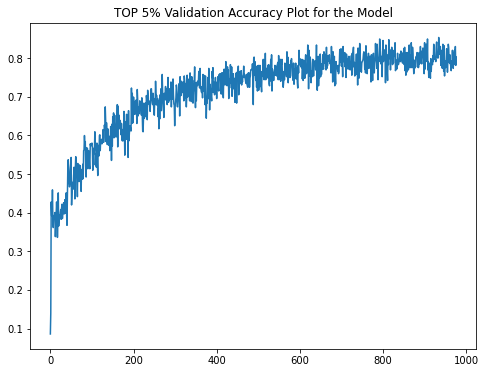

In [28]:
plt.figure(figsize=(8,6))
plt.title("TOP 5% Validation Accuracy Plot for the Model")
plt.plot([x.detach().item()  for x in val_top_5_acc])

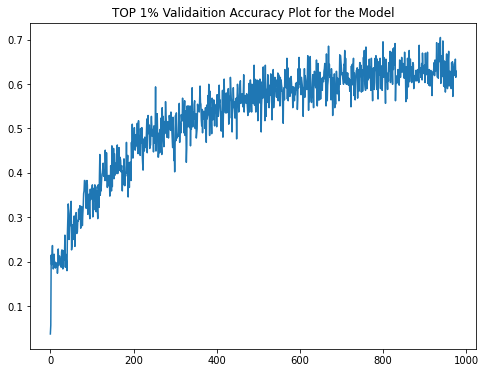

In [29]:
plt.figure(figsize=(8,6))
plt.title("TOP 1% Validaition Accuracy Plot for the Model")
plt.plot([x.detach().item()  for x in val_top_1_acc])

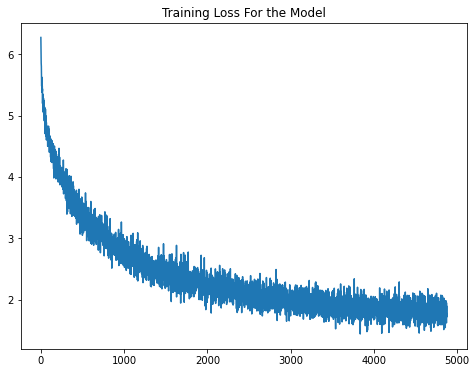

In [30]:
plt.figure(figsize=(8,6))
plt.title("Training Loss For the Model")
plt.plot([x.detach().item()  for x in total_loss])

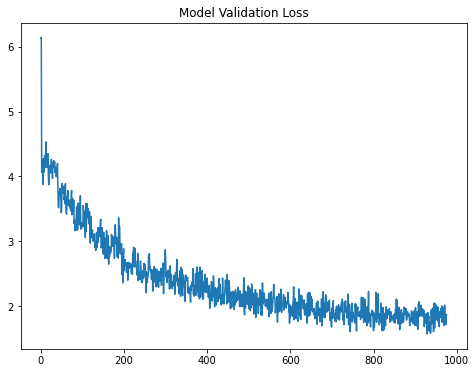

In [31]:
plt.figure(figsize=(8,6))
plt.title("Model Validation Loss")
plt.plot([x.detach().item()  for x in val_total_loss])

### FINE TUNING AND TRAINING FOR CIFAR100 dataset.


- The model Trained above will be used.
- PyTorch lightning module class will be used to encapsulate the logic (INHERITED as above). 
- The pretrained resnet18 backbone on cifar10 will be used here for downstream task, without its projection head. A single linear layer will be added at the head on top to act as a classfier.

In [32]:
"""
Images will only be converted to tensors and normalized its pixels
"""
transforms_ftn = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
cifar100_train_img_data = torchvision.datasets.CIFAR100(root="datasets/cifar100", train=True, download=True,transform=transforms_ftn)
cifar_100_test_img_data = torchvision.datasets.CIFAR100(root="datasets/cifar100", train=False, download=True,transform=transforms_ftn)


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting datasets/cifar100/cifar-100-python.tar.gz to datasets/cifar100
Files already downloaded and verified


In [33]:
"""
THese are the 10 selected labels that will be used for training and evaluation of the above trained model
"""
# get random labels 


labels_selected = [0,1,2,3,4,5,6,7,8,9]



In [34]:
# np.where() labels_selected
class SelectedData(torch.utils.data.Dataset):
    """
    This takes a list of dataset and convert it to tensor dataset
    The list has only 10 selected class labels
    """
    def __init__(self, img_list):
        super(SelectedData, self).__init__()
        self.img_list = img_list

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
        
        return img
        

In [35]:
cifar100_train_img_data[0][1]

19

In [36]:
"""
Exclude other classes not wanted and remain with onlt 10 random labels for model training.
"""
selected_train = [cifar100_train_img_data[i] for i in range(len(cifar100_train_img_data)) if cifar100_train_img_data[i][1] in labels_selected]
selected_test = [cifar_100_test_img_data[i] for i in range(len(cifar_100_test_img_data)) if cifar_100_test_img_data[i][1] in labels_selected]

In [56]:
"""
Create a tensor dataset from these newly selected classes with 10 random labels
"""
selected_train_imgs = SelectedData(selected_train)
selected_test_imgs = SelectedData(selected_test)

In [57]:
"""
We seen that the new data selected has 5000 images up from 50000
"""
len(selected_train_imgs), len(selected_test_imgs), len(cifar100_train_img_data)

(5000, 1000, 50000)

In [39]:
# check size
print("Number of training examples:", len(cifar100_train_img_data))
print("Number of test examples:", len(cifar_100_test_img_data))

Number of training examples: 50000
Number of test examples: 10000


In [40]:
cifar100_train_img_data[48][1]

89

In [41]:


loss_fn = nn.CrossEntropyLoss()

class DownStream_Model(pl.LightningModule):
    """
    Down Stream Model
    """
    def __init__(self, img_features, n_classes, lr, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()

        #this is the layer to be added on top as a classifier of n classes
        self.model = nn.Linear(img_features, n_classes)

        self.optimizer = optim.SGD(self.parameters(),lr=self.hparams.lr,weight_decay=self.hparams.weight_decay, momentum = 0.9)

        self.scheduler =  optim.lr_scheduler.MultiStepLR(self.optimizer,milestones=[int(self.hparams.max_epochs*0.65),int(self.hparams.max_epochs*0.8)],gamma=0.85)
    def configure_optimizers(self):
        """Optimized params tuned"""
        return [self.optimizer], [self.scheduler]

    def pass_through_network(self, batch, train=True):
        """
        PASS INPUTS THROUGH THE NETWORK
        """
        img_feats, labels = batch
        preds = self.model(img_feats)

        #self.optimizer.zero_grad()
        # Get the loss
        loss = loss_fn(preds, labels)

        #loss.backward()
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        #self.optimizer.step()


        if train == "False1":
            mode = "test"
            test_loss.append(loss)
            test_acc.append(acc)            
        if train:
            mode ='train'
            val_loss.append(loss)
            val_acc.append(acc)
        else:
            mode ='val'
            val_loss.append(loss)
            val_acc.append(acc)

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self.pass_through_network(batch, True)

    def validation_step(self, batch, batch_idx):
        self.pass_through_network(batch,False)

    def test_step(self, batch, batch_idx):
        self.pass_through_network(batch, "False1")

In [42]:
# prepare features to conform with the model architecture.
from copy import deepcopy
@torch.no_grad()
def create_data_features(model, dataset):
    """
    Prepare some features
    """
    #get the base without the head
    backbone_model = deepcopy(model.resnet18)
    # add head
    backbone_model.fc = nn.Identity()
    backbone_model.eval()
    backbone_model.to(device)
    img_feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)):
        batch_imgs = batch_imgs.to(device)
        batch_feats = backbone_model(batch_imgs)
        img_feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    img_feats = torch.cat(img_feats, dim=0)
    labels = torch.cat(labels, dim=0)
    labels, idxs = labels.sort()
    img_feats = img_feats[idxs]
    return data.TensorDataset(img_feats, labels)

### Data Preparation
- The datasets are prepared here.
- Full cifar100 with all classes and also the one with 10 classes will be prepaired here to get their features

In [43]:
cifar100_train_feats_simclr = create_data_features(simclr_model, cifar100_train_img_data)
cifar100_test_feats_simclr = create_data_features(simclr_model, cifar_100_test_img_data)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [58]:
selected10_cifar100_train_feats_simclr = create_data_features(simclr_model, selected_train_imgs)
selected10_cifar100_test_feats_simclr = create_data_features(simclr_model, selected_test_imgs)



  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [45]:
# loss plot and accuracy
def getGraphsForModel():
    """
    Draws a graph for the results
    """
    fig, axes = plt.subplots(1, 2 , figsize=(20,7))
    axes[0].set_title('VALIDATION Loss' , c='r' , fontsize=15)
    axes[0].plot([x.detach().item()  for x in val_loss], color='orange', label='val loss')
    axes[0].legend(loc='best')
    axes[1].set_title('VALIDATION Classification Accuracy' , c ='r' , fontsize=15)
    axes[1].plot([x.detach().item()  for x in val_acc], color='blue', label='val accuracy')
    axes[1].legend(loc = "best")
    
    plt.show()
    
    fig, axes = plt.subplots(1, 2 , figsize=(20,7))
    axes[0].set_title('TEST Loss' , c='r' , fontsize=15)
    axes[0].plot([x.detach().item()  for x in test_loss], color='green', label='Test loss')

    axes[0].legend(loc='best')
    axes[1].set_title('TEST Classification Accuracy' , c ='r' , fontsize=15)
    axes[1].plot([x.detach().item()  for x in test_acc], color='purple', label='val accuracy')
    axes[1].legend(loc = "best")
    

### Train FOr 10 selected classes

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

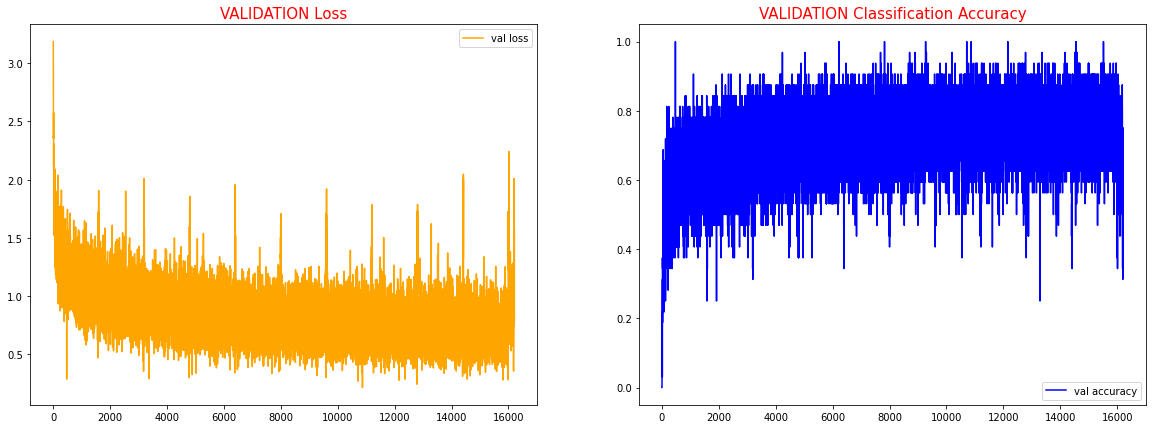

Results:    {'train_res': [{'train_loss': 0.8957672119140625, 'train_acc': 0.6883999705314636}], 'test_res': [{'train_loss': 1.1893023252487183, 'train_acc': 0.6029999852180481}]}


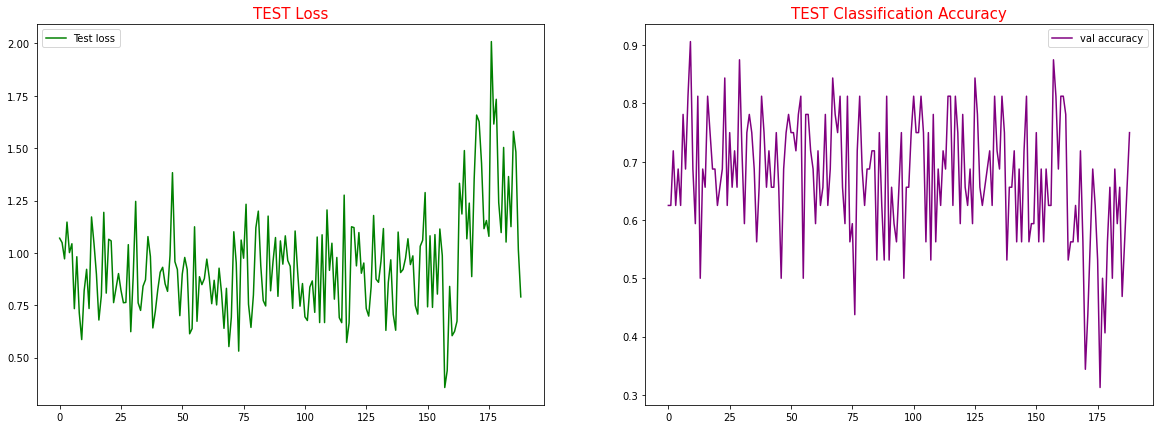

In [59]:
# # create a trainer for cifar100

# def get_indices(dataset,class_name):
#     indices =  []
#     for i in range(len(dataset.targets)):
#         if dataset.targets[i] == class_name:
#             indices.append(i)
#     return indices


# idx = get_indices(dataset1, [0,1,2,3,4,5,6,7,8,9])


def Trainer_Cateries_Selected(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    cifar100_10_trainer = pl.Trainer(default_root_dir="./Cifar100_10",gpus=1 if str(device)=="cuda:0" else 0,max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=10)
    #don;t show logs
    cifar100_10_trainer.logger._default_hp_metric = None
    #create data loaders
    train_loader = data.DataLoader(selected10_cifar100_train_feats_simclr, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(selected10_cifar100_test_feats_simclr, batch_size=batch_size, shuffle=False)
    
    #train
    saved_filename = os.path.join(CHECKPOINT_PATH, f"DownStream{model_suffix}.ckpt")
    if os.path.isfile(saved_filename):
        print(f" Downstream Model Saved is being Loaded from {saved_filename}")
        model = DownStream_Model.load_from_checkpoint(saved_filename)
    else:
        pl.seed_everything(2022)
        model = DownStream_Model(**kwargs)
        cifar100_10_trainer.fit(model, train_loader, test_loader)
        model = DownStream_Model.load_from_checkpoint(cifar100_10_trainer.checkpoint_callback.best_model_path)

        #test the model
    train_result = cifar100_10_trainer.test(model, train_loader, verbose=False)
    test_result = cifar100_10_trainer.test(model, test_loader, verbose=False)
    return model, {"train_res":train_result, "test_res":test_result}




train_acc =[]
train_loss =[]

val_acc =[]
val_loss =[]

test_acc =[]
test_loss =[]

final_10_model, curr_res = Trainer_Cateries_Selected(batch_size=32,train_feats_data=selected10_cifar100_train_feats_simclr,
                                            test_feats_data=selected10_cifar100_test_feats_simclr,model_suffix="100_10_epochs",
                                            img_features=selected10_cifar100_train_feats_simclr.tensors[0].shape[1],
                                            n_classes=10,lr=1e-3,weight_decay=1e-3)

# plot the results
getGraphsForModel()
print("Results:   ", curr_res)

In [61]:
curr_res

print('Results For the 10 Selected Categories from CIfar100 Are')
print(f"Training Accuracy:   {curr_res['train_res'][0]['train_acc']}")
print(f"Training Loss:   {curr_res['train_res'][0]['train_loss']}")

print(f"Validation Accuracy:   {curr_res['test_res'][0]['train_acc']}")
print(f"Validation Loss:   {curr_res['test_res'][0]['train_loss']}")

Results For the 10 Selected Categories from CIfar100 Are
Training Accuracy:   0.6883999705314636
Training Loss:   0.8957672119140625
Validation Accuracy:   0.6029999852180481
Validation Loss:   1.1893023252487183


### Results on Selected Classes

- The model trained on class labels from 0 to 9 had an accuracy of about 60% on test dataset which was slightly lower by 8% from the training accuracy.
- This model was trained on a 
```
     Batch size = 32,
     Number of epochs = 100
     Learning Rate = 0.001
     Weight Decay = 0.001
     Number of classes =10 (Only the selected one)
```
- Training curves for both loss and accuracy was always shifting and did not have a constant movement either increase for accuracy and reduction for loss.


### Training On all 100 Labels

### At first, Lets get 1%, 10% and 50% of the labels to train it with.
- In this case, the model will be trained on varied ranges of labels i,e 1%, 10% and 50%.
- Below is the implimentation of this part

In [62]:
def split_small_version(img_data, size_per_label):
    """Split labels with a given percentage"""
    return  data.TensorDataset(
        *[t.unflatten(0, (10, -1))[:,:size_per_label].flatten(0, 1) for t in img_data.tensors]
    )

In [49]:
# create a trainer for cifar100
def Trainer_cifar100(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=50, **kwargs):
    """
    Trainer for cifar100.
    It is based on logistic regression model as defined above in the downstream structure.
    """
    cifar100_trainer = pl.Trainer(default_root_dir="./Cifar100",gpus=1 if str(device)=="cuda:0" else 0,max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=10)
    #don;t show logs
    cifar100_trainer.logger._default_hp_metric = None
    #create data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False)
    
    #train
    saved_filename = os.path.join(CHECKPOINT_PATH, f"DownStream{model_suffix}.ckpt")
    if os.path.isfile(saved_filename):
        print(f" Downstream Model Saved is being Loaded from {saved_filename}")
        model = DownStream_Model.load_from_checkpoint(saved_filename)
    else:
        pl.seed_everything(2022)
        model = DownStream_Model(**kwargs)
        cifar100_trainer.fit(model, train_loader, test_loader)
        model = DownStream_Model.load_from_checkpoint(cifar100_trainer.checkpoint_callback.best_model_path)

        #test the model
    train_result = cifar100_trainer.test(model, train_loader, verbose=False)
    test_result = cifar100_trainer.test(model, test_loader, verbose=False)
    return model, {"train_res":train_result, "test_res":test_result}

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

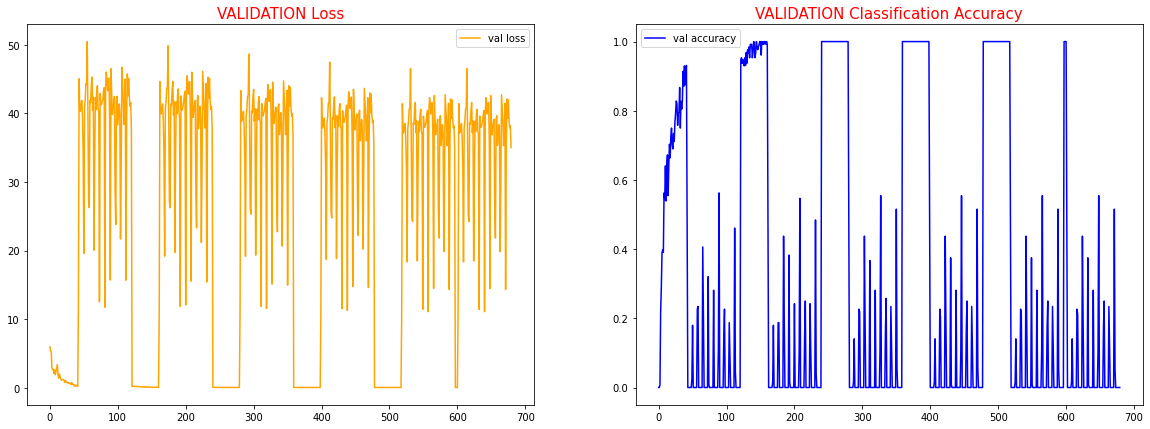

{1: {'train_res': [{'train_loss': 0.01983615569770336, 'train_acc': 1.0}], 'test_res': [{'train_loss': 35.534637451171875, 'train_acc': 0.055799998342990875}]}}


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

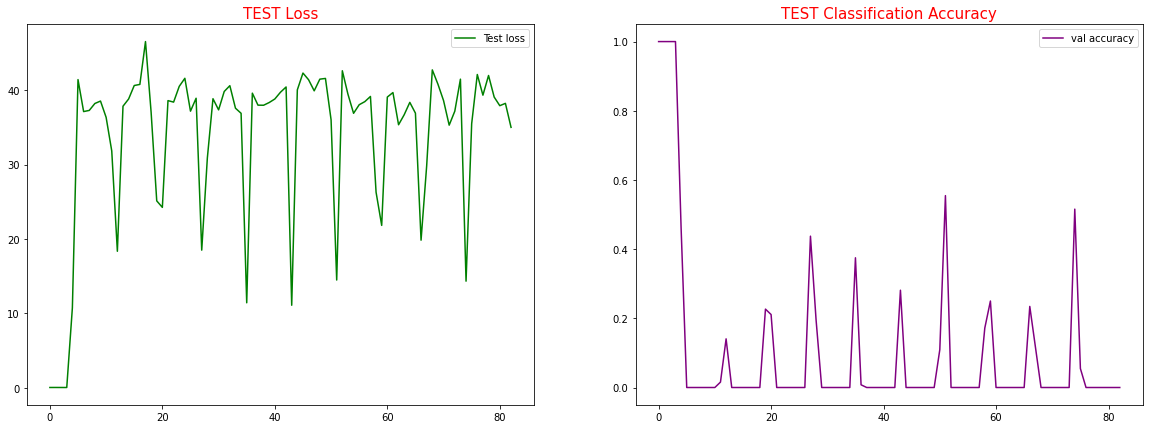

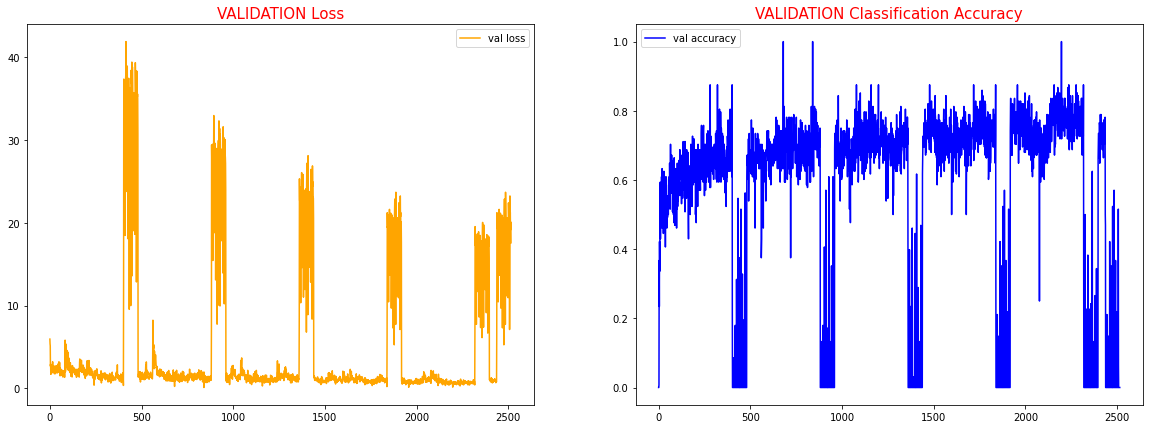

{1: {'train_res': [{'train_loss': 0.01983615569770336, 'train_acc': 1.0}], 'test_res': [{'train_loss': 35.534637451171875, 'train_acc': 0.055799998342990875}]}, 10: {'train_res': [{'train_loss': 0.9240875244140625, 'train_acc': 0.729200005531311}], 'test_res': [{'train_loss': 18.404510498046875, 'train_acc': 0.06120000034570694}]}}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

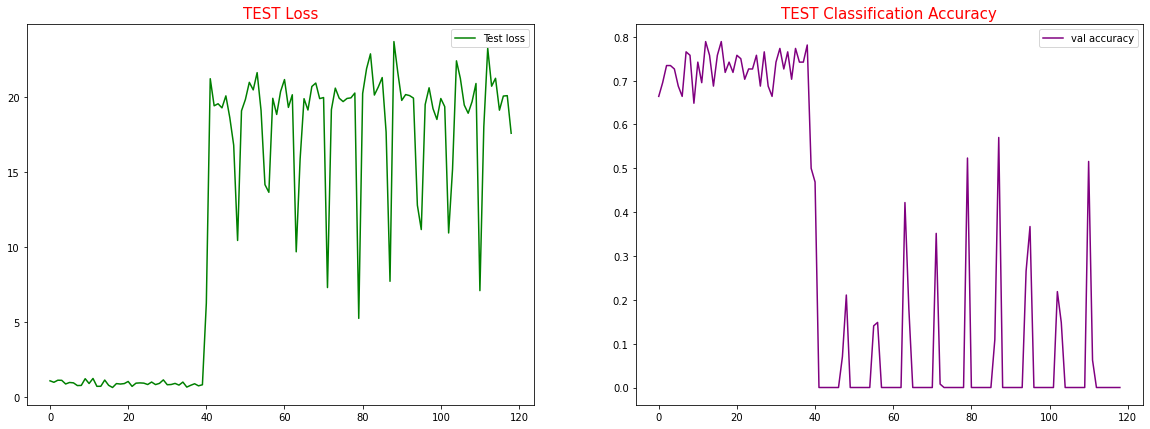

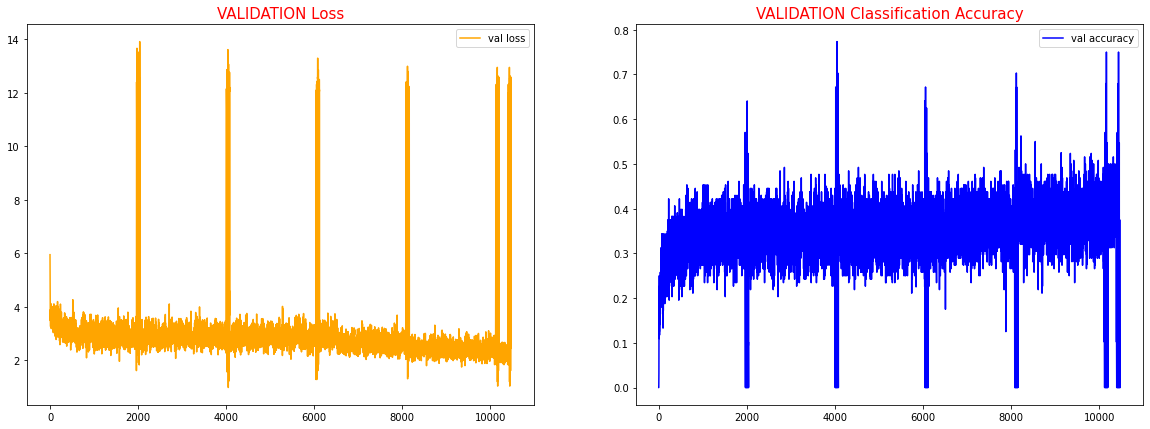

{1: {'train_res': [{'train_loss': 0.01983615569770336, 'train_acc': 1.0}], 'test_res': [{'train_loss': 35.534637451171875, 'train_acc': 0.055799998342990875}]}, 10: {'train_res': [{'train_loss': 0.9240875244140625, 'train_acc': 0.729200005531311}], 'test_res': [{'train_loss': 18.404510498046875, 'train_acc': 0.06120000034570694}]}, 50: {'train_res': [{'train_loss': 2.2569468021392822, 'train_acc': 0.4070799946784973}], 'test_res': [{'train_loss': 7.450175762176514, 'train_acc': 0.1647000014781952}]}}


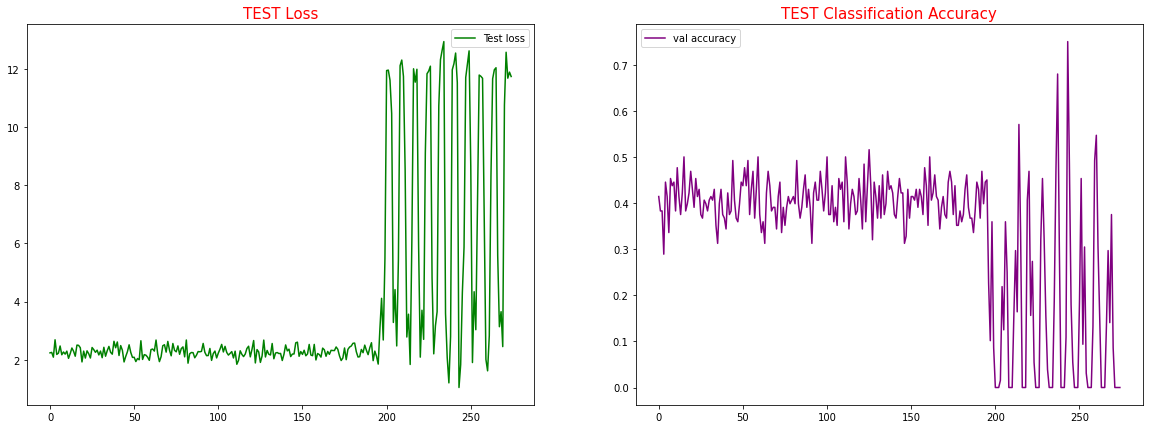

In [50]:
results = {}



# class Wise accuracy for 1, 10 and 50 
for lbl_size in [1,10,50]:
    # These lists will hold the accuracies
    train_acc =[]
    train_loss =[]

    val_acc =[]
    val_loss =[]

    test_acc =[]
    test_loss =[]

    sub_train_set = split_small_version(cifar100_train_feats_simclr, (5000 * lbl_size//100))
    _, curr_res = Trainer_cifar100(batch_size=128,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=cifar100_test_feats_simclr,
                                        model_suffix=lbl_size,
                                        img_features=cifar100_train_feats_simclr.tensors[0].shape[1],
                                        n_classes=100,
                                        lr=4e-2,
                                        weight_decay=2e-3)
    results[lbl_size] = curr_res
    getGraphsForModel()
    print(results)

In [51]:
results

{1: {'train_res': [{'train_loss': 0.01983615569770336, 'train_acc': 1.0}],
  'test_res': [{'train_loss': 35.534637451171875,
    'train_acc': 0.055799998342990875}]},
 10: {'train_res': [{'train_loss': 0.9240875244140625,
    'train_acc': 0.729200005531311}],
  'test_res': [{'train_loss': 18.404510498046875,
    'train_acc': 0.06120000034570694}]},
 50: {'train_res': [{'train_loss': 2.2569468021392822,
    'train_acc': 0.4070799946784973}],
  'test_res': [{'train_loss': 7.450175762176514,
    'train_acc': 0.1647000014781952}]}}

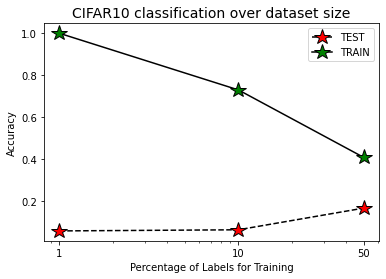

Test accuracy for   1% images  label: 5.58%
Test accuracy for  10% images  label: 6.12%
Test accuracy for  50% images  label: 16.47%


In [63]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]['test_res'][0]['train_acc'] for k in dataset_sizes]
train_scores = [results[k]['train_res'][0]['train_acc'] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="r", markersize=16, label="TEST")
plt.plot(dataset_sizes, train_scores,  color="#000", marker="*", markeredgecolor="#000", markerfacecolor="g", markersize=16, label= "TRAIN")
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("CIFAR10 classification over dataset size", fontsize=14)
plt.xlabel("Percentage of Labels for Training")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d}% images  label: {100*score:4.2f}%')

### Results on 1%,10% and 50%.

- As it would be expected, the classificatiion perfonaces improves with an increase in percentage of labels given when results are based on accuracy for the testing. With 1%, an accuracy of 5,5% is achieved which increases to 16% when about 50% labels are provided. This shows that with enough classes availability, the model might have a better results.

- Below are parameters used for the above model
```
     Batch size = 128,
     Number of epochs = 50
     Learning Rate = 4e-2
     Weight Decay = 2e-3
     Number of classes =100
```

### Overall Training for the whole cifar100 dataset with all classes.
- Same model as above and parameters will be used to train 100 classes

In [65]:
# These lists will hold the accuracies
train_acc =[]
train_loss =[]

val_acc =[]
val_loss =[]

test_acc =[]
test_loss =[]




_, curr_res = Trainer_cifar100(batch_size=64,
                                train_feats_data=sub_train_set,
                                test_feats_data=cifar100_test_feats_simclr,
                                model_suffix="100_epochs",
                                img_features=cifar100_train_feats_simclr.tensors[0].shape[1],
                                n_classes=100,
                                lr=1e-3,
                                weight_decay=1e-3)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

In [66]:
curr_res

{'train_res': [{'train_loss': 1.8430644273757935,
   'train_acc': 0.48576000332832336}],
 'test_res': [{'train_loss': 7.176121711730957,
   'train_acc': 0.2011999934911728}]}

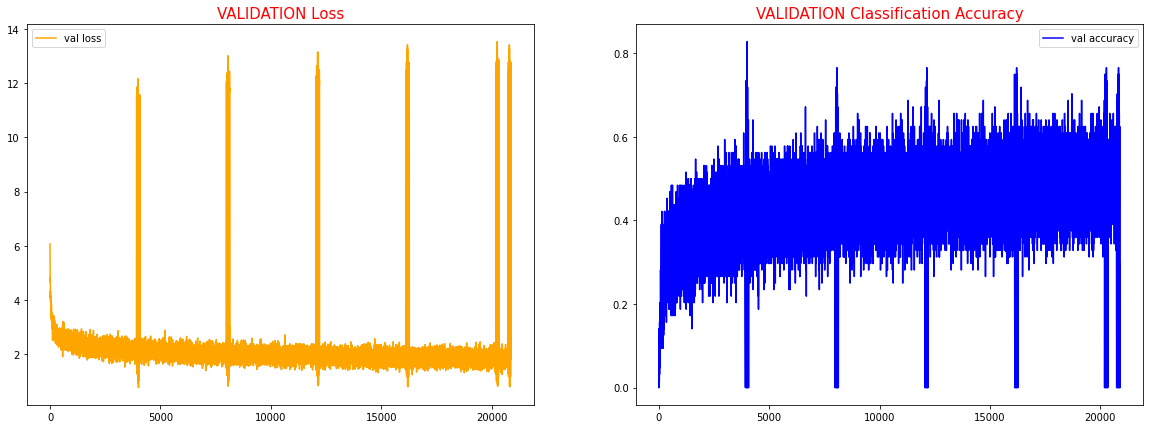

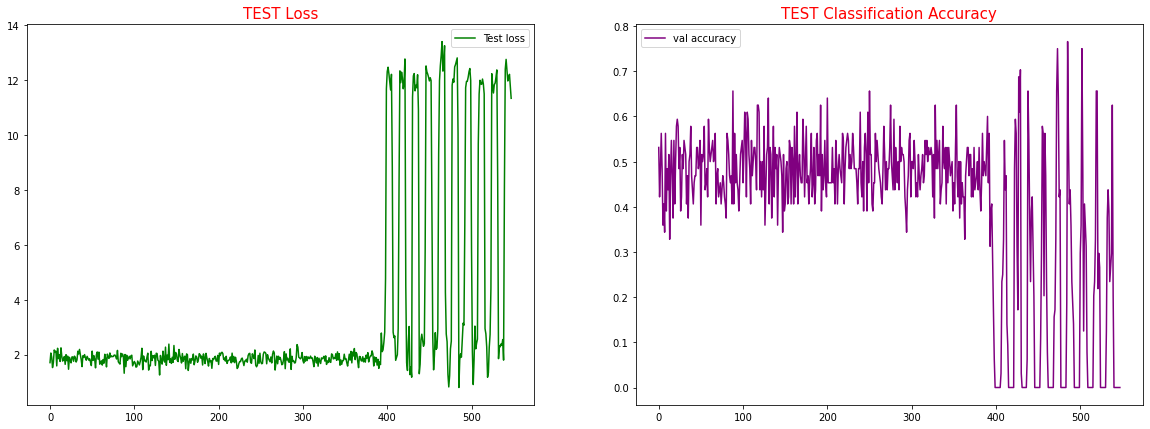

In [68]:
getGraphsForModel()

In [69]:

print('Results For the 10 Selected Categories from CIfar100 Are')
print(f"Training Accuracy:   {curr_res['train_res'][0]['train_acc']}")
print(f"Training Loss:   {curr_res['train_res'][0]['train_loss']}")

print(f"Validation Accuracy:   {curr_res['test_res'][0]['train_acc']}")
print(f"Validation Loss:   {curr_res['test_res'][0]['train_loss']}")

Results For the 10 Selected Categories from CIfar100 Are
Training Accuracy:   0.48576000332832336
Training Loss:   1.8430644273757935
Validation Accuracy:   0.2011999934911728
Validation Loss:   7.176121711730957


### Overall Results.

- The above model was trained with the following parameters;
    
    ```
     Batch size = 64,
     Number of epochs = 50
     Learning Rate = 1e-3
     Weight Decay = 1e-3
     Number of classes =100
```

- As it can be seen from the results above, The model perfomance was above 20% on validation set while for the training was about 48%.
- Validation phase had alot of loss which is about 7 while training loss was about 2.
- THis might indicate the model is overfitting and need a change in architecture.

### Comparison of the 3 Scenarios.
- Log loss and Accuracy was the main metrics used for model evaluation in this project. Validation accuracy was used to keep checkpoint of the best model.
- Model perfomances on less classes in more than on more classes i.e, For 10 classes with same model configuration, the downstream model was able to achieve over 60% accuracy on validation set for cifar100 while on 100 classes the model had achieved about 20%. This could also be seen on the 1%,10% and 50% of the class labels provinsion, the model had a very loss accuracy although a trend was observed that accuracy increases with increase in number of class labels in the whole images.


- On observation of the graph curves made, the graph also shows a varied trend on perfomance. There was an irregular trend for both training and validation on all 3 cases except for the self supervised learning where the curves showed a consisted trend. In self supervised learning, the accuracies increases as traing batchs and epochs increase while losses were reducing. This is not the same trend as it is in the case of Down stream Learning as trends of these curves keeps on shifting between high points and low points.